<a href="https://colab.research.google.com/github/srishti-56/ai-experiments/blob/main/Finetune%20Phi2%20to%20fix%20inaccurate%20statements%20(QA_Legal_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fix Inaccurate Statements (experiment)  
The goal of this experiment is to **revise and fix inaccurate statements** in an answer, given the ground data, by fine-tuning a small generative LLM model.


### Types of hallucinations
For the examples, consider a news article about music - [Taylor Swift vs. The Beatles: who's bigger?](https://theweek.com/culture-life/music/taylor-swift-vs-the-beatles-whos-bigger)

#### 1. Factual or Entity
Hallucination of factual data (explicitly named in the text) - these can consist of names, dates, nouns, actions etc captured in the ground truth text, and can be mapped as entities.     

> **Question**  
> Which artist has had the most songs at number one on the Hot 100 chart?

> **Answer (with hallucination)**   
> ***Taylor Swift***  - with 20 number ones in total.  

> **Correct Answer**   
> ***The Beatles*** - with 20 number ones in total.   


#### 2. Intent or Reasoning
Hallucination in intent or reasoning (implicit in the text) - these can consist of causal inferences, reasoning, intents implied by the text.  

> **Question**  
> Why might Taylor Swift’s concerts generate seismological readings similar to an earthquake?    

> **Answer (with hallucination)**   
> Taylor Swift’s concerts might generate seismological readings similar to an earthquake ***because the fans’ sing so loudly that the vibrations*** can be detected by seismological equipment.   

> **Correct Answer**    
> Taylor Swift’s concerts might generate seismological readings similar to an earthquake ***because the fans’ enthusiastic reactions, likely - cheering, jumping, and dancing -*** create significant vibrations that can be detected by seismological equipment.   

#### 3. Source Conflation
Hallucination in the answer when the model collates information from multiple sources.


**This experiment only examines factual hallucinations. The tuned model will focus on replacing the correct fact using the ground truth text**.   
Note: The concept of token-level misses (eg. the strawberry discussion) could apply here?



---



## Data
### Dataset    
  + Chose the Open Australian Legal QA dataset - it contains 2,124 questions and answers on the legal cases in Australia.
  + The answers were generated by gpt-4 on the Open Australian Legal Corpus dataset.

### Data Preparation (Inject Hallucination)
A hallucination is injected into the answer by replacing an entity in the sentence.
  + Use spacy to extract entities from the Answers and the Prompt Snippets.
  + Replace an **entity in the answer** with an entity from the **prompt** (eg. Dates, Names, Organisations etc).
  + To make it obvious, prefer to replace longer entities, and only when the prompt contains > 1 entity type to replace.

> **Prompt**   
> The plaintiff claims that he was overseas ... This appeal has been lodged out of time. **The decision of the Local Court was made on 4 October 2005. The summons was filed on 8 June 2006, some seven months out of time. No explanation has been provided for this delay**....it appears that Mr Nasr sought and was granted a number of adjournments while he was overseas in China.

> **Incorrect Statement**  
> [2006] NSWSC 1018, the plaintiff's appeal was lodged out of time because the summons was filed on **1992**, seven months after the decision of the Local Court was made on 4 October 2005.

> **Correctly Rewritten Statement**   
> [2006] NSWSC 1018, the plaintiff's appeal was lodged out of time because the summons was filed on **8 June 2006**, seven months after the decision of the Local Court was made on 4 October 2005.


### Sample Input Dataset:
![Image description]( https://i.imgur.com/FB29wFj.png)



---





## Finetuning Microsoft's Phi-2 model

Finetuning the model consists of
1. Generating a prompt with the original case data, the incorrect sentence and the corrected sentence.

The prompts vary in length,  with the majority around 550 tokens. For compute tradeoff purposes, we select a max seq length size of 850 tokens.
![Image description](https://i.imgur.com/mPqUFch.png)

2. Tokenizing the data and add padding.

3. Next, we test how the base Phi-2 model does -


> **Ground Data**   
> In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson failed to deliver the goods as per their agreement dated January 15, 2024.

> **Incorrect sentence**  
> The plaintiff, John Johnson filed a lawsuit due to a breach of an agreement made on January 15, 2024.

> **Corrected sentence**    
> Jane Smith sued John Johnson in court for breaching their agreement signed on January 15, 2024. Smith claimed that Johnson did not fulfill his obligations under the contract by failing to provide the agreed-upon goods.


4. Train the model by applying QLoRA, and tweak parameters for compute tradeoffs  
TODO: All parameter insights etc


5. Test out the fine-tuend model again!

Test with different prompts.   

> Prompt 1 (no variation): Rewrite and correct the inaccuate statement to be accurate to the ground data document.

> **Corrected sentence**   
> In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson breached their agreement by failing to deliver the goods as agreed upon on January 15, 2024.  
> **Corrected statement**   
Smith alleges that Johnson breached their agreement by not delivering the goods as agreed upon on January 15, 2024.   
> **Corrected statement**   
Smith alleges that Johnson breached

---

> Prompt 2 (do not explain reasoning): Rewrite and correct the inaccuate statement to be accurate to the ground data document.
You must only answer with the rewritten statement and nothing else. Do not explain your reasoning.



> **Corrected sentence**:   
> Jane Smith sued John Johnson in court for breach of contract, claiming that he did not fulfill his obligations under the agreement signed on January 15, 2024.   
**Corrected sentence**:   
> The rewritten statement is accurate because it correctly identifies the parties involved in the lawsuit and explains the reason for the legal action taken by the plaintiff. It also specifies the date of the agreement and the nature of the breach.   
**Corrected sentence**:   
> Jane Smith sued John Johnson in court


---

> Prompt 3 (include the question): Rewrite and correct the inaccuate statement to be accurate to the ground data document.
You must only answer with the rewritten statement and nothing else. Do not explain your reasoning.
Question:



> **Corrected sentence**:   
> Jane Smith, the plaintiff, filed a lawsuit against John Johnson, the defendant, for breach of contract. Smith claimed that Johnson breached their agreement by failing to deliver the goods as agreed upon on January 15, 2024.
GROUND DATA START    GROUND DATA END.   

*Extra data is generated


### Install and Import

In [ ]:
from huggingface_hub import login

login("<hugging-face-token>")

from google.colab import drive
import pandas as pd
import numpy as np
import torch

from datasets import Dataset, DatasetDict, load_dataset

from transformers import (
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoTokenizer,
)
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments
from trl import SFTTrainer

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import statistics
import random
import spacy
import re
import os

import wandb

np.random.seed(42)


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Inject Hallucinations
(only run once, processed data saved to file)

In [ ]:
# store entities in 'answer' for each row as a list of (word, label)
def extract_entities_answer(doc):
  entities = [(ent.text, ent.label_, ent.start_char) for ent in doc.ents]
  return entities

# store entities in 'ground truth prompt' as a dictionary for lookup/replace operation
def extract_entities_prompt(doc):
  entities = {label: [] for label in set(ent.label_ for ent in doc.ents)}
  for ent in doc.ents:
    entities[ent.label_].append(ent.text)
  return entities

# only target answer entities if the corresponding prompt entity has an item to replace it with
def get_valid_targets(entities):
  valid_target_entities = []
  for label, values in entities.items():
    if len(values) > 1:
      valid_target_entities.append(label)
  return valid_target_entities

# prefer longer entities
def find_longest_entity(sentences, answer_entities):
  entities_in_sentences = []
  for x in answer_entities:
    for s in sentences:
      if str(x[0]) in str(s):
        entities_in_sentences.append(x)

  # sort by length
  entities_in_sentences = sorted(entities_in_sentences, key=lambda x: len(x[0].split()), reverse=True)
  return entities_in_sentences[0]



def inject_hallucination(row, sample_split):
  sentences = list(row['nlp_extract_answer'].sents)

  # Prefer longer sentences
  sentence_lengths = [len(sentence.text.split()) for sentence in sentences]
  percentile_length = np.percentile(sentence_lengths, 90)
  filtered_sentences = [sentence for sentence in sentences if len(sentence.text.split()) >= percentile_length]

  try:
    if row.name < sample_split:

      # Find the target entity and injection entity
      answer_entities = [x for x in row['answer_entities'] if x[1] in row['valid_targets']]
      longest_entity = find_longest_entity(filtered_sentences, answer_entities)
      target_entity, target_label, target_idx = longest_entity
      inject_hallucination_entity = random.choice([entity for entity in row['prompt_entities'][target_label] if entity != target_entity])

      # Update data with the original sentence and the hallucinated sentence
      selected_sentence = [x for x in filtered_sentences if str(target_entity) in str(x)][0]
      row['original_sentence'] = selected_sentence.text
      row['edited_sentence'] = selected_sentence.text.replace(target_entity, inject_hallucination_entity)
      row['is_hallucination'] = 1

    else:
      row['original_sentence'] = filtered_sentences[0].text
      row['edited_sentence'] = filtered_sentences[0].text
      row['is_hallucination'] = 0

  except Exception as e:
    print(f"{row.name} not processed. Exception {e}")
    row['original_sentence'] = filtered_sentences[0].text
    row['edited_sentence'] = filtered_sentences[0].text
    row['is_hallucination'] = 0

  return row



In [ ]:
df = pd.read_json("drive/MyDrive/rewrite-exp/qa.jsonl", lines=True)

# Extract entities to edit
nlp = spacy.load("en_core_web_sm")
df['nlp_extract_answer'] = df['answer'].apply(lambda x: nlp(x))
df['nlp_extract_prompt'] = df['prompt'].apply(lambda x: nlp(x))


In [ ]:
# Find Valid Entities
df['prompt_entities'] = df['nlp_extract_prompt'].apply(extract_entities_prompt)
df['valid_targets'] = df['prompt_entities'].apply(get_valid_targets)
df['answer_entities'] = df['nlp_extract_answer'].apply(extract_entities_answer) # note: could also capture the start index of each entity in case of duplicates, in this case will always use the first occurrence

# Inject Hallucinations
split = int(0.75 * df.shape[0])
df = df.apply(inject_hallucination, sample_split=split, axis=1)
df_save = df[['prompt', 'original_sentence', 'edited_sentence', 'is_hallucination']]


In [ ]:
print(f"For example, \nEntire Answer: {df.iloc[0]['answer']} \n Selected Sentence: {df.iloc[0]['original_sentence']} \n Sentence after Hallucination: {df.iloc[0]['edited_sentence']}")

For example, 
Entire Answer: In Nasr v NRMA Insurance [2006] NSWSC 1018, the plaintiff's appeal was lodged out of time because the summons was filed on 8 June 2006, seven months after the decision of the Local Court was made on 4 October 2005. No explanation was provided for this delay. 
 Selected Sentence: [2006] NSWSC 1018, the plaintiff's appeal was lodged out of time because the summons was filed on 8 June 2006, seven months after the decision of the Local Court was made on 4 October 2005. 
 Sentence after Hallucination: [2006] NSWSC 1018, the plaintiff's appeal was lodged out of time because the summons was filed on some seven months, seven months after the decision of the Local Court was made on 4 October 2005.


In [ ]:
df_train = df_save[df_save['is_hallucination'] == 1]
df_test = df_save[df_save['is_hallucination'] == 0]

In [ ]:
# df_train.to_json("drive/MyDrive/rewrite-exp/legal_qa_train_4.json", orient="records", lines=True)
# df_test.to_json("drive/MyDrive/rewrite-exp/legal_qa_test_4.json", orient="records", lines=True)


## Finetune Phi-2

Followed this excellent tutorial - [here](https://github.com/brevdev/notebooks/blob/main/phi2-finetune-own-data.ipynb)



### 1. Install

In [ ]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib einops
!pip install -q wandb -U


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy

In [ ]:
## Use Wandb to track metrics
wandb.login()

wandb_project = "rewrite-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

### 2. Load Dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset = load_dataset('json', data_files='drive/MyDrive/rewrite-exp/legal_qa_train_4.json', split='train')
eval_dataset = load_dataset('json', data_files='drive/MyDrive/rewrite-exp/legal_qa_test_4.json', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
df = pd.read_json('drive/MyDrive/rewrite-exp/legal_qa_train_3.json', lines=True)

In [ ]:
df.head()

,prompt,original_sentence,edited_sentence,is_hallucination
0,3 The plaintiff claims that he was overseas wh...,"[2006] NSWSC 1018, the plaintiff's appeal was ...","[2006] NSWSC 1018, the plaintiff's appeal was ...",1
1,29 The Appellant also gave evidence that she h...,She stated that she had heard that Mr Nguyen w...,She stated that she had heard that Mr Appellan...,1
2,CITATION: Inspector Phillip Estreich v Hannas ...,In the case of Inspector Phillip Estreich v Ha...,In the case of Inspector Phillip Estreich v Ha...,1
3,Poisons List Amendment Order 2012 I make the f...,The Poisons List Amendment Order 2012 in Tasma...,The Poisons List Amendment Order 2012 in Tasma...,1
4,SIMMS INVESTMENTS PTY LTD (ACN 093 504 511) Si...,In the case Australian Securities and Investme...,In the case Commonwealth v Letten (No 24) [201...,1


In [ ]:
train_dataset

Dataset({
    features: ['prompt', 'original_sentence', 'edited_sentence', 'is_hallucination'],
    num_rows: 1828
})

#### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [ ]:
def formatting_func(example):

    text = ("You must rewrite and correct this incorrect sentence to be accurate based on the ground data. "
    + "Incorrect Sentence: \n"
    + example['edited_sentence']
    + "\n"
    + "Corrected Sentence: \n"
    + example['original_sentence']
    + "\n"
    + "GROUND DATA START: "
    + "\n"
    + example['prompt']
    + "\n"
    + "GROUND DATA END "
    + "\n\n"
    + "You must only answer with the rewritten statement and nothing else. Do not explain your reasoning."
    + "Corrected sentence:  "
    + example['original_sentence'])
    return text

### 3. Load Base Model



Let's now load Phi-2 using 8-bit quantization!

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, torch_dtype=torch.float16, load_in_8bit=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### 4. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Reformat the prompt and tokenize each sample:

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/1828 [00:00<?, ? examples/s]

Map:   0%|          | 0/1828 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

3656


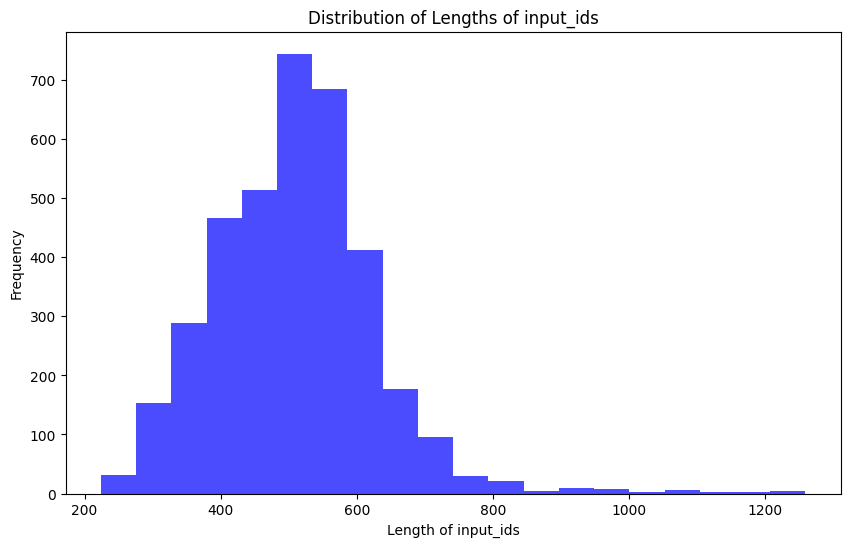

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.


Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [ ]:
max_length = 850 # This was an appropriate max length for my dataset. To run on <15GB of RAM, max length <500

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/1828 [00:00<?, ? examples/s]

Map:   0%|          | 0/1828 [00:00<?, ? examples/s]

Generally, each `input_ids` should be padded on the left with the `eos_token` (50256) and there should be an `eos_token` 50256 added to the end, and the prompt should start with a `bos_token` (?). However, I'm getting an error with Phi-2's tokenizer. GPU credits for whoever can resolve this!

Hopefully should work just fine as-is.

Now all the samples should be the same length, `max_length`.

3656


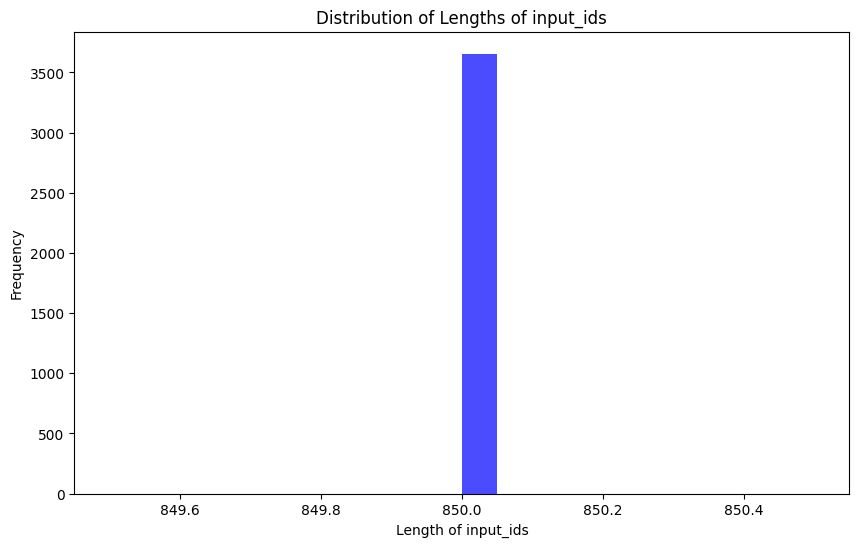

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?
Actually does OK, but edits the sentence structure etc significantly

In [ ]:
eval_prompt = """ Rewrite and correct the inaccuate statement to be accurate to the ground data document.
You must only answer with the rewritten statement and nothing else. Do not explain your reasoning.

Incorrect sentence:
The plaintiff, John Johnson filed a lawsuit due to a breach of an agreement made on January 15, 2024.


### Ground Data:
In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson failed to deliver the goods as per their agreement dated January 15, 2024.

### Corrected sentence:


"""

In [ ]:
# Init an eval tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    use_fast=False, # needed for now, should be fixed soon
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


 Rewrite and correct the inaccuate statement to be accurate to the ground data document.
You must only answer with the rewritten statement and nothing else. Do not explain your reasoning.

Incorrect sentence:
The plaintiff, John Johnson filed a lawsuit due to a breach of an agreement made on January 15, 2024.


### Ground Data:
In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson failed to deliver the goods as per their agreement dated January 15, 2024.

### Corrected sentence:


Corrected Sentence: 
Jane Smith sued John Johnson in court for breaching their agreement signed on January 15, 2024. Smith claimed that Johnson did not fulfill his obligations under the contract by failing to provide the agreed-upon goods.



### 5. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. Let's set up our LoRA layers.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to some linear layers of the model. Those layers are `Wqkv`, `fc1`, `fc2`.

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
                (lora_dropout): ModuleDict(
                  (default

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "Wqkv",
        "fc1",
        "fc2",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581515


See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): Embedding(51200, 2560)
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiSdpaAttention(
              (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
              (rotary_emb): PhiRotaryEmbedding()
            )
            (mlp): PhiMLP(
              (activation_fn): NewGELUActivation()
              (fc1): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
                (lora_dropout): ModuleDict(
                  (default

### 6. Run Training!

In [ ]:
from accelerate import Accelerator
accelerator = Accelerator()

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "rewrite-finetune-2"
base_model_name = "phi2"
run_name = base_model_name + "-" + project
output_dir = "drive/MyDrive/rewrite-exp/" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

In [ ]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained("drive/MyDrive/rewrite-exp/results/phi2-rewrite-finetune-2")

### 7. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`).

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base model from the Huggingface Hub:

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Phi2, same as before
    device_map="auto",
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = tokenizer.eos_token

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel
ft_model = PeftModel.from_pretrained(base_model, f"{output_dir}/checkpoint-500")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better.

In [ ]:
eval_prompt_1 = """ Rewrite and correct the inaccuate statement to be accurate to the ground data document.

Incorrect sentence:
The plaintiff, John Johnson filed a lawsuit due to a breach of an agreement made on January 15, 2024.


### Ground Data:
In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson failed to deliver the goods as per their agreement dated January 15, 2024.

### Corrected sentence:


"""

eval_promp_2 = """ Rewrite and correct the inaccuate statement to be accurate to the ground data document.
You must only answer with the rewritten statement and nothing else. Do not explain your reasoning.

Incorrect sentence:
The plaintiff, John Johnson filed a lawsuit due to a breach of an agreement made on January 15, 2024.


### Ground Data:
In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson failed to deliver the goods as per their agreement dated January 15, 2024.

### Corrected sentence:


"""

eval_prompt_3 = """ Rewrite and correct the inaccuate statement to be accurate to the ground data document.
You must only answer with the rewritten statement and nothing else. Do not explain your reasoning.
Question: Who filed the lawsuit?

Incorrect sentence:
The plaintiff, John Johnson filed a lawsuit due to a breach of an agreement made on January 15, 2024.


### Ground Data:
In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson failed to deliver the goods as per their agreement dated January 15, 2024.

### Corrected sentence:


"""

In [ ]:
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.11)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Rewrite and correct the inaccuate statement to be accurate to the ground data document.
You must only answer with the rewritten statement and nothing else. Do not explain your reasoning.
Question: Who filed the lawsuit?

Incorrect sentence:
The plaintiff, John Johnson filed a lawsuit due to a breach of an agreement made on January 15, 2024.


### Ground Data:
In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson failed to deliver the goods as per their agreement dated January 15, 2024.

### Corrected sentence:


Corrected sentence: 
Jane Smith, the plaintiff, filed a lawsuit against John Johnson, the defendant, for breach of contract. Smith claimed that Johnson breached their agreement by failing to deliver the goods as agreed upon on January 15, 2024.
GROUND DATA START    GROUND DATA END    GROUND DATA START    GROUND DATA END    GROUND DATA START    GROUND DATA END    GROUND

In [ ]:
## Eval Prompt Variation 1 contains only 'Rewrite and correct the inaccuate statement to be accurate to the ground data document.'

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 Given the following legal data, rewrite the inaccuate statement to be accurate to the ground data.
Sentence:
The plaintiff, John Johnson filed a lawsuit due to a breach of an agreement made on January 15, 2024.


### Ground Data:
In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson failed to deliver the goods as per their agreement dated January 15, 2024.

### Rewritten sentence:
Corrected sentence:
In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson breached their agreement by failing to deliver the goods as agreed upon on January 15, 2024.
Corrected statement:
Smith alleges that Johnson breached their agreement by not delivering the goods as agreed upon on January 15, 2024.
Corrected statement:
Smith alleges that Johnson breached

In [ ]:
## Eval Prompt Variation 2 contains 'answer with rewritten statement / do not explain reasoning'

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 Rewrite and correct the inaccuate statement to be accurate to the ground data document.
You must only answer with the rewritten statement and nothing else. Do not explain your reasoning.

Incorrect sentence:
The plaintiff, John Johnson filed a lawsuit due to a breach of an agreement made on January 15, 2024.


### Ground Data:
In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson failed to deliver the goods as per their agreement dated January 15, 2024.

### Corrected sentence:


Corrected sentence:
Jane Smith sued John Johnson in court for breach of contract, claiming that he did not fulfill his obligations under the agreement signed on January 15, 2024.
Corrected explanation: The rewritten statement is accurate because it correctly identifies the parties involved in the lawsuit and explains the reason for the legal action taken by the plaintiff. It also specifies the date of the agreement and the nature of the breach.
Corrected statement:
Jane Smith sued John Johnson in court

In [ ]:
## Eval Prompt Variation 2 contains Question

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
 Rewrite and correct the inaccuate statement to be accurate to the ground data document.
You must only answer with the rewritten statement and nothing else. Do not explain your reasoning.
Question: Who filed the lawsuit?

Incorrect sentence:
The plaintiff, John Johnson filed a lawsuit due to a breach of an agreement made on January 15, 2024.


### Ground Data:
In the case of Smith v. Johnson, the plaintiff, Jane Smith, filed a lawsuit against the defendant, John Johnson, for breach of contract. Smith alleged that Johnson failed to deliver the goods as per their agreement dated January 15, 2024.

### Corrected sentence:


Corrected sentence:
Jane Smith, the plaintiff, filed a lawsuit against John Johnson, the defendant, for breach of contract. Smith claimed that Johnson breached their agreement by failing to deliver the goods as agreed upon on January 15, 2024.
GROUND DATA START    GROUND DATA END    GROUND DATA START    GROUND DATA END    GROUND DATA START    GROUND DATA END    GROUND DATA START    GROUND DATA END    GROUND DATA ST